<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/Data%20Science%20Projects/SkimLit/SkimLit_Project_Multiple_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct


fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# start the experiment usign 20K dataset with numbers replace by '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [ ]:
# create function to read in all of the lines of target text file
def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath
  Returns:
      a list of strings with one string per line from the target filename.
      '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# read the training lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## turn into certain format

* turn to dictionary
```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines': 11},
  ...]

```

In [ ]:
# write a function to turn each datasets into the above format
def preprocess_text_with_line_numbers(filename):
  '''
  return a list of dictionary of abstract line data.
  Take in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number the target line is.
  '''
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = '' # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith('###'): # check if it is ID line
      abstract_id = line
      abstract_lines = ''  # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if the line is new line(\n)
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] # get the label
        line_data['text'] = target_text_split[1].lower() # get the text
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract (start from 0)
        abstract_samples.append(line_data)

    else: # if the above conditions are not fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # It's another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
# check the first dataset of training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df  =pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

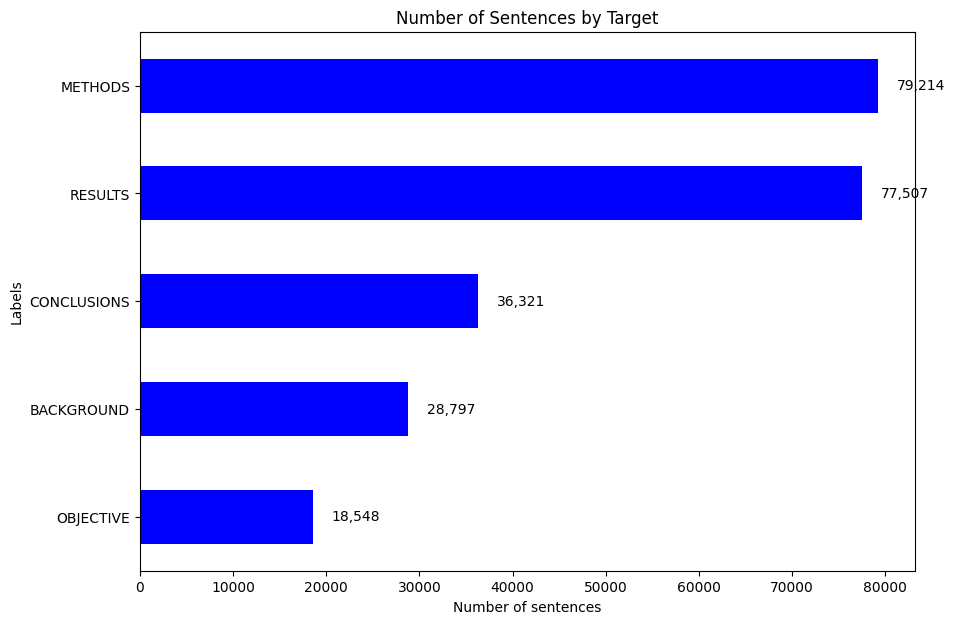

In [ ]:
# get whole data distribution
import matplotlib.pyplot as plt
train_targets = train_df['target'].value_counts()
val_targets = val_df['target'].value_counts()
test_targets = test_df['target'].value_counts()

targets_df = pd.DataFrame({'train': train_targets, 'val': val_targets, 'test': test_targets})

total_counts = targets_df.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 7))

total_counts.sort_values().plot(kind='barh', color='blue', ax=ax)

ax.set_title('Number of Sentences by Target')
ax.set_xlabel('Number of sentences')
ax.set_ylabel('Labels')

for i in ax.patches:
    ax.text(i.get_width() + 2000,
            i.get_y() + i.get_height() / 2,
            f'{int(i.get_width()):,}',
            ha='left',
            va='center',
            color='black')

plt.show()

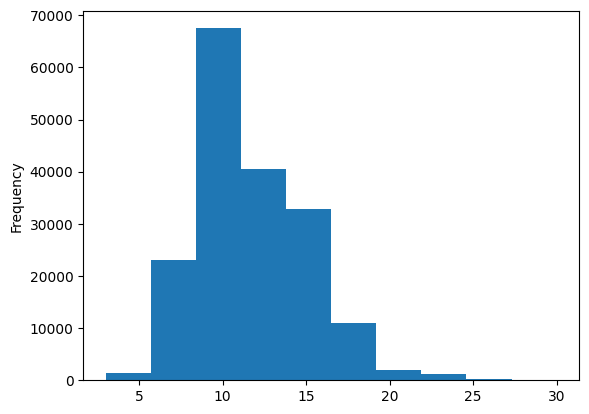

In [ ]:
train_df.total_lines.plot.hist();

## Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

## Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
# need to set sparse to false, otherwise cannot turn into tensor
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get the class name back
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0 baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create Pipeline
model_0 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

# Fit the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the baseline model
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# Make prediction using baseline model
baseline_pred = model_0.predict(val_sentences)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# use helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-15 14:26:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-15 14:26:25 (115 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results
baseline_results = calculate_results(val_labels_encoded, baseline_pred)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# check the sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sen_len = np.mean(sent_lens)
avg_sen_len

26.338269273494777

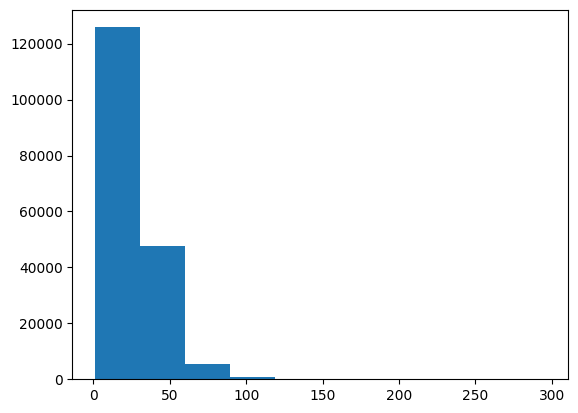

In [ ]:
# check the distribution
plt.hist(sent_lens, bins=10)
plt.show()

In [ ]:
# How long of a sentence lenght cover 95%
# It seems 95% sentences is less than 55 token
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

## Create text vecotorizer layer

* Using PubMed_20k_RCT Dataset, the paper told us the vocab legth is 68K

* (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

# max_tokens = number of words in vocabulary
text_vectorizer = TextVectorization(max_tokens=68000, output_sequence_length=55)

In [ ]:
# adapt in training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test the random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text:\n{text_vectorizer([target_sentence])}')

Text:
after treatment , the reduced vp of vertebral artery was not improved apparently as compared with that before treatment in the control group , vp in blood velocity abnormality ( including vascular spasm , stenosis or reduced velocity ) of vertebral artery and basilar artery was all improved as compared with that before treatment in the two groups ( p < @ ) , and the improvements in the observation group were more obvious than those in the control group ( p < @ ) .

Length of text: 86

Vectorized text:
[[   21    19     2   191  6576     4  2776   543    10    31   170  3423
     25    34     7    28   129    19     5     2    35    13  6576     5
    107  1462  7276   251   758 12957  1484    16   191  1462     4  2776
    543     3 13491   543    10    62   170    25    34     7    28   129
     19     5     2    51    24    14     3]]


In [ ]:
# How many words in training vocabulary
rct_20K_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20K_text_vocab)}')
print(f'Most common words in the vocab: {rct_20K_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20K_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create Embedding

In [ ]:
token_embed = Embedding(input_dim=len(rct_20K_text_vocab),
                        output_dim=128, # different size cause different training time, the bigger the longer
                        mask_zero=True, # save space, efficiency computing
                        name='token_embedding')

print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n {vectorized_sentence}\n')
embed_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embed_sentence}\n')
print(f'Embedded sentence shape: {embed_sentence.shape}')

Sentence before vectorization:
 after treatment , the reduced vp of vertebral artery was not improved apparently as compared with that before treatment in the control group , vp in blood velocity abnormality ( including vascular spasm , stenosis or reduced velocity ) of vertebral artery and basilar artery was all improved as compared with that before treatment in the two groups ( p < @ ) , and the improvements in the observation group were more obvious than those in the control group ( p < @ ) .

Sentence after vectorization (before embedding):
 [[   21    19     2   191  6576     4  2776   543    10    31   170  3423
     25    34     7    28   129    19     5     2    35    13  6576     5
    107  1462  7276   251   758 12957  1484    16   191  1462     4  2776
    543     3 13491   543    10    62   170    25    34     7    28   129
     19     5     2    51    24    14     3]]

Sentence after embedding:
 [[[-0.03019643 -0.02455009  0.0470461  ... -0.02021303 -0.00839729
    0.00072

## Create datasets

* It can run faster when using tf.data API

In [ ]:
# Turn the data into tensorflow dataset
# One-hot encoding makes the features more compatible with neural networks.
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

**Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)**


In [ ]:
# Create 1D model
inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors) # create embedding
x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = GlobalMaxPooling1D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_1 = Model(inputs, outputs)

# compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                             

In [ ]:
# Fit the model
# Inorder to get speed to experiment, so only fit 10% of dataset
history_1 = model_1.fit(train_dataset, steps_per_epoch=int(0.1 * len(train_dataset)), epochs=5,
                        validation_data=val_dataset, validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 30s 52ms/step - loss: 0.8391 - accuracy: 0.6844 - val_loss: 0.5875 - val_accuracy: 0.7839
Epoch 2/5
562/562 [==============================] - 25s 45ms/step - loss: 0.5782 - accuracy: 0.7906 - val_loss: 0.5334 - val_accuracy: 0.7992
Epoch 3/5
562/562 [==============================] - 27s 48ms/step - loss: 0.5434 - accuracy: 0.8024 - val_loss: 0.5181 - val_accuracy: 0.8118
Epoch 4/5
562/562 [==============================] - 26s 46ms/step - loss: 0.5226 - accuracy: 0.8094 - val_loss: 0.5162 - val_accuracy: 0.8019
Epoch 5/5
562/562 [==============================] - 29s 51ms/step - loss: 0.5331 - accuracy: 0.8047 - val_loss: 0.4954 - val_accuracy: 0.8142


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4982 - accuracy: 0.8175


[0.4982145428657532, 0.817489743232727]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.3765685e-01, 3.5032144e-01, 1.2837873e-02, 1.7028841e-01,
         2.8895438e-02],
        [5.9872210e-01, 2.7221444e-01, 3.6630959e-03, 9.6794009e-02,
         2.8606258e-02],
        [4.5414791e-01, 2.8666001e-02, 1.4310254e-02, 5.0188059e-01,
         9.9523482e-04],
        ...,
        [2.3106278e-04, 1.1273307e-03, 9.6886745e-03, 1.1427621e-04,
         9.8883867e-01],
        [5.9099556e-03, 7.5640255e-01, 2.4197610e-02, 2.8524275e-03,
         2.1063745e-01],
        [6.8430521e-02, 9.2220277e-01, 5.7880781e-03, 1.9291083e-03,
         1.6494959e-03]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 81.74897391764861,
 'precision': 0.8190945776210621,
 'recall': 0.8174897391764862,
 'f1': 0.8145878435830921}

## Model 2: Feature extraction with pretrained token embeddings

* Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)



In [ ]:
# Download pretrained tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test on random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Text:\n{random_train_sentence}\n')
embed_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{embed_sentence[0][:30]}\n')
print(f'Embedded sentence shape: {embed_sentence.shape}')
print(f'Length of embedded sentence: {len(embed_sentence[0])}')

Text:
linear mixed models were used to test the significance of the change in audit and dudit scores over time .

Sentence after embedding:
[ 0.0037184  -0.035721   -0.00533328 -0.05804954 -0.05315614  0.02796734
 -0.05598419 -0.01350024 -0.03685066  0.04921627 -0.05605056 -0.00657368
  0.05054975 -0.00359031 -0.04349243  0.00757773  0.02603168  0.0231679
 -0.03534289  0.03568928 -0.06852159  0.03049254 -0.05918074  0.06740426
  0.01064195 -0.01448392  0.06060838  0.0888186   0.06470972  0.05582403]

Embedded sentence shape: (1, 512)
Length of embedded sentence: 512


In [ ]:
# build feature extraction model using TF hub layer
# expect the shape be list
inputs = Input(shape=[], dtype=tf.string)
pretrained_embed = tf_hub_embedding_layer(inputs)
x = Dense(128, activation='relu')(pretrained_embed)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_2 = Model(inputs, outputs)

# compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                           

In [ ]:
history_2 = model_2.fit(train_dataset, steps_per_epoch=int(0.1 * len(train_dataset)), epochs=5,
                        validation_data=val_dataset, validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 8s 10ms/step - loss: 0.8938 - accuracy: 0.6443 - val_loss: 0.7714 - val_accuracy: 0.7001
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.7347 - accuracy: 0.7146 - val_loss: 0.7058 - val_accuracy: 0.7271
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.7068 - accuracy: 0.7260 - val_loss: 0.6791 - val_accuracy: 0.7397
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6753 - accuracy: 0.7426 - val_loss: 0.6595 - val_accuracy: 0.7523
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6830 - accuracy: 0.7372 - val_loss: 0.6420 - val_accuracy: 0.7517


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.6510 - accuracy: 0.7506


[0.6510467529296875, 0.7505958080291748]

In [ ]:
# make prediction
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 [==============================] - 7s 7ms/step


(array([[6.8095064e-01, 1.6442966e-01, 1.4116401e-03, 1.4897160e-01,
         4.2364169e-03],
        [4.4302857e-01, 4.8401338e-01, 3.0794572e-03, 6.6576168e-02,
         3.3025073e-03],
        [3.9862254e-01, 2.8886152e-02, 5.8033831e-02, 4.9671879e-01,
         1.7738607e-02],
        ...,
        [2.4068762e-04, 7.6352473e-04, 3.5834420e-02, 1.6513153e-04,
         9.6299618e-01],
        [6.0557509e-03, 3.6170464e-02, 4.7560495e-01, 2.9325727e-03,
         4.7923622e-01],
        [9.3251005e-02, 8.7813467e-01, 1.5175823e-02, 1.3382613e-03,
         1.2100300e-02]], dtype=float32),
 (30212, 5))

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# calcualte result
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 75.05957897524162,
 'precision': 0.7468309466726105,
 'recall': 0.7505957897524163,
 'f1': 0.7455678615678207}

## Model 3: Conv1D with character embeddings

* The difference between a character and token embedding is that the character embedding is created using sequences split into characters `(e.g. hello -> [h, e, l, l, o])` where as a token embedding is created on sequences split into tokens.

In [ ]:
# Create a character lebel tokenizer, Make function to split sentences into characters
def split_chars(text):
  chars = list(text)
  return ' '.join(chars)

In [ ]:
# test the function
split_chars(random_train_sentence)

'l i n e a r   m i x e d   m o d e l s   w e r e   u s e d   t o   t e s t   t h e   s i g n i f i c a n c e   o f   t h e   c h a n g e   i n   a u d i t   a n d   d u d i t   s c o r e s   o v e r   t i m e   .'

In [ ]:
# split sequence level into character level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# find the average character length
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

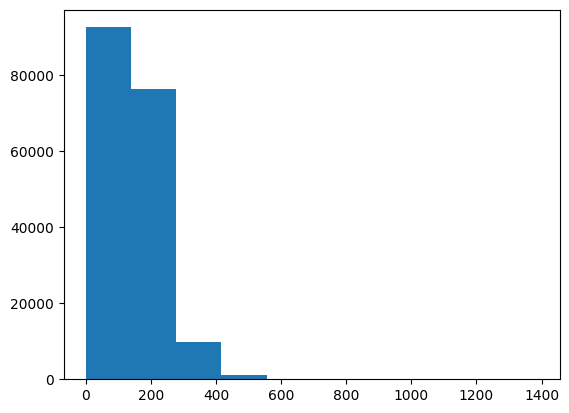

In [ ]:
plt.hist(char_len, bins=10);

In [ ]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [ ]:
# Get all characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create char-level token vectorizer instance
num_char_tokens = len(alphabet) + 2 #add 2 for space and OOV(Out of vocabulary)
char_vectorizer = TextVectorization(max_tokens=num_char_tokens, output_sequence_length=output_seq_char_len, standardize='lower_and_strip_punctuation',
                                    name='char_vectorizer')

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
# check character vocabulary stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of characters in vocab: {len(char_vocab)}')
print(f'Most common vocab: {char_vocab[:5]}')
print(f'Least common vocab: {char_vocab[-5:]}')


Number of characters in vocab: 28
Most common vocab: ['', '[UNK]', 'e', 't', 'i']
Least common vocab: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n{random_train_chars}')
print(f'\nLength of chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n{vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
i n   t h e   m o t o r   t a s k   s t u d y   o f   t e n   h e a l t h y   s u b j e c t s   ,   o u r   m e t h o d   r e v e a l e d   c o m p o n e n t s   w i t h   c o n c o r d a n t   s p a t i a l   a n d   t e m p o r a l   f e a t u r e s   a s   e x p e c t e d   f r o m   t h e   u n i l a t e r a l   m o t o r   t a s k s   .

Length of chars: 145

Vectorized chars:
[[ 4  6  3 13  2 15  7  3  7  8  3  5  9 23  9  3 16 10 19  7 17  3  2  6
  13  2  5 12  3 13 19  9 16 22 27  2 11  3  9  7 16  8 15  2  3 13  7 10
   8  2 21  2  5 12  2 10 11  7 15 14  7  6  2  6  3  9 20  4  3 13 11  7
   6 11  7  8 10  5  6  3  9 14  5  3  4  5 12  5  6 10  3  2 15 14  7  8
   5 12 17  2  5  3 16  8  2  9  5  9  2 24 14  2 11  3  2 10 17  8  7 15
   3 13  2 16  6  4 12  5  3  2  8  5 12 15  7  3  7  8  3  5  9 23  9  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0

### Create character embedding

In [ ]:
char_embed = Embedding(input_dim=num_char_tokens, # number of different characters
                       output_dim=25, # embedding dimension of each character, use 25 or 50 is perfect, according the paper
                       mask_zero=False, # Using mask_zero=True ensures that padding values do not affect model learning, allowing the model to focus on the actual data
                       name='char_embed')

# test out character embedding layer
print(f'charified text:\n {random_train_chars}\n')
char_embed_test = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_test}\n")
print(f"Character embedding shape: {char_embed_test.shape}")

charified text:
 i n   t h e   m o t o r   t a s k   s t u d y   o f   t e n   h e a l t h y   s u b j e c t s   ,   o u r   m e t h o d   r e v e a l e d   c o m p o n e n t s   w i t h   c o n c o r d a n t   s p a t i a l   a n d   t e m p o r a l   f e a t u r e s   a s   e x p e c t e d   f r o m   t h e   u n i l a t e r a l   m o t o r   t a s k s   .

Embedded chars (after vectorization and embedding):
[[[-0.00390239 -0.04202533 -0.00922061 ... -0.00660287 -0.02660675
    0.03333615]
  [ 0.03741529  0.00105983  0.04159797 ... -0.04801067 -0.00630444
    0.0327315 ]
  [-0.03691075 -0.00961689  0.01248219 ...  0.00900762  0.01221906
   -0.02054675]
  ...
  [ 0.00224568  0.03137532 -0.02925479 ... -0.01055963  0.02844863
   -0.04540349]
  [ 0.00224568  0.03137532 -0.02925479 ... -0.01055963  0.02844863
   -0.04540349]
  [ 0.00224568  0.03137532 -0.02925479 ... -0.01055963  0.02844863
   -0.04540349]]]

Character embedding shape: (1, 290, 25)


In [ ]:
# Create character 1D model
inputs = Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embedding)
x = GlobalMaxPooling1D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_3 = Model(inputs, outputs)

# compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 5)                 325 

In [ ]:
# Before fitting our model on the data, create char-level batched PrefetchedDataset's, it will fit faster
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_3 = model_3.fit(train_char_dataset, steps_per_epoch=int(0.1 * len(train_char_dataset)), epochs=5,
                        validation_data=val_char_dataset, validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 7ms/step - loss: 1.2595 - accuracy: 0.4898 - val_loss: 1.0271 - val_accuracy: 0.5914
Epoch 2/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9965 - accuracy: 0.6024 - val_loss: 0.9349 - val_accuracy: 0.6270
Epoch 3/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9212 - accuracy: 0.6397 - val_loss: 0.8586 - val_accuracy: 0.6626
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8673 - accuracy: 0.6643 - val_loss: 0.8331 - val_accuracy: 0.6659
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8583 - accuracy: 0.6631 - val_loss: 0.8106 - val_accuracy: 0.6818


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8243 - accuracy: 0.6849


[0.8242747783660889, 0.6848934292793274]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs, model_3_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[0.2860556 , 0.48187378, 0.02287622, 0.19133577, 0.0178586 ],
        [0.06859652, 0.83182824, 0.00173184, 0.08769138, 0.01015191],
        [0.21803693, 0.17363106, 0.15643792, 0.43887144, 0.01302271],
        ...,
        [0.02884603, 0.03768873, 0.06721114, 0.03593226, 0.83032185],
        [0.03747879, 0.15387996, 0.3321805 , 0.07394056, 0.4025202 ],
        [0.31979573, 0.4990121 , 0.1419048 , 0.0333818 , 0.0059056 ]],
       dtype=float32),
 (30212, 5))

In [ ]:
model_preds = tf.argmax(model_3_pred_probs, axis=1)
model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_preds)
model_3_results

{'accuracy': 68.48934198331789,
 'precision': 0.6848756473174332,
 'recall': 0.6848934198331789,
 'f1': 0.6809375369021716}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level model

2. Create a character-level model

3. Combine (using layers.Concatenate) the outputs of 1 and 2

4. Build a series of output layers

5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs model, the shape is list, because the tensorflow hub expect it
token_inputs = Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation='relu')(token_embeddings)
token_model = Model(inputs=token_inputs,
                    outputs=token_outputs)

# 2. Setup char inputs model
char_inputs = Input(shape=[], dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(25))(char_embeddings) # 25 is hidden units in LSTM
char_model = Model(inputs=char_inputs,
                   outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = Concatenate(name='token_char_concat')([token_model.output,
                                                           char_model.output])

# 4. Create output layers, adding in Dropout
combined_dropout = Dropout(0.5)(token_char_concat)
combined_dense = Dense(200, activation='relu')(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = Model([token_model.inputs, char_model.inputs],
                outputs=output_layer,
                name='model_4_hybrid_embedding')

In [ ]:
model_4.summary()

Model: "model_4_hybrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token

In [ ]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# combine chars and tokens into dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_4 = model_4.fit(train_char_token_dataset, steps_per_epoch=int(0.1 * len(train_char_token_dataset)), epochs=5,
                        validation_data=val_char_token_dataset, validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 60s 99ms/step - loss: 0.9669 - accuracy: 0.6134 - val_loss: 0.7784 - val_accuracy: 0.7008
Epoch 2/5
562/562 [==============================] - 54s 96ms/step - loss: 0.7953 - accuracy: 0.6919 - val_loss: 0.7143 - val_accuracy: 0.7327
Epoch 3/5
562/562 [==============================] - 53s 94ms/step - loss: 0.7632 - accuracy: 0.7092 - val_loss: 0.6803 - val_accuracy: 0.7467
Epoch 4/5
562/562 [==============================] - 53s 95ms/step - loss: 0.7315 - accuracy: 0.7210 - val_loss: 0.6613 - val_accuracy: 0.7530
Epoch 5/5
562/562 [==============================] - 53s 93ms/step - loss: 0.7402 - accuracy: 0.7186 - val_loss: 0.6496 - val_accuracy: 0.7543


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 23s 25ms/step - loss: 0.6578 - accuracy: 0.7472


[0.6578243374824524, 0.7472196221351624]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 24ms/step


array([[5.98981678e-01, 2.29540288e-01, 4.61564306e-03, 1.58116728e-01,
        8.74563772e-03],
       [4.38373595e-01, 3.93319309e-01, 1.00584514e-02, 1.50689170e-01,
        7.55947828e-03],
       [3.71382475e-01, 6.46008328e-02, 1.05787896e-01, 4.21980619e-01,
        3.62481512e-02],
       ...,
       [1.31500681e-04, 1.05949899e-03, 4.34065536e-02, 5.37529668e-05,
        9.55348670e-01],
       [4.93931025e-03, 2.39130240e-02, 4.64945704e-01, 1.82364427e-03,
        5.04378378e-01],
       [3.16078454e-01, 4.90896702e-01, 1.44737452e-01, 8.81734770e-03,
        3.94699909e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 74.72196478220575,
 'precision': 0.7439257175936133,
 'recall': 0.7472196478220574,
 'f1': 0.7415353884431426}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embedding

In [ ]:
# Find out how many line numbers
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

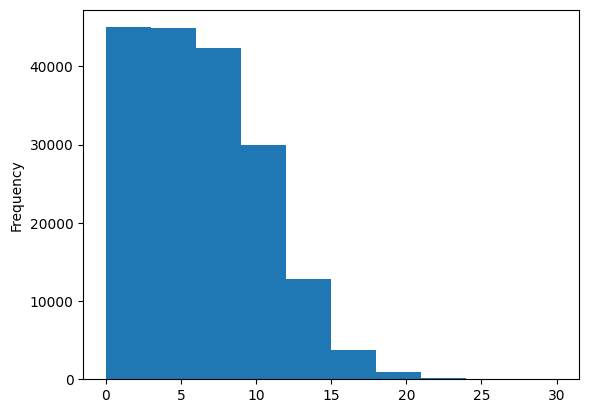

In [ ]:
# check the distribution of line numbers
train_df['line_number'].plot.hist();

In [ ]:
# Use tensorflow to create one hot encoding, that can fit in model
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_number_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

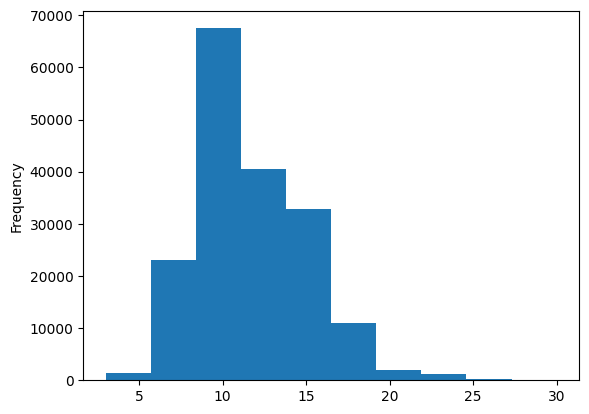

In [ ]:
train_df['total_lines'].plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20, value 20 cover 98%
np.percentile(train_df['total_lines'], 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### Build thribrid embedding model

In [ ]:
train_line_number_one_hot[0].shape, train_line_number_one_hot[0].dtype

(TensorShape([15]), tf.float32)

In [ ]:
train_total_lines_one_hot[0].shape, train_total_lines_one_hot[0].dtype

(TensorShape([20]), tf.float32)

In [ ]:
# 1. Token inputs
token_inputs = Input(shape=[], dtype=tf.string, name='token_input')
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation='relu')(token_embedding)
token_model = Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(25))(char_embedding)
char_model = Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. line numbers model
line_number_inputs = Input(shape=(15,), dtype=tf.int32, name='line_number_input')
x = Dense(32, activation='relu')(line_number_inputs)
line_number_model = Model(inputs=line_number_inputs, outputs=x)

# 4. total lines model
total_line_inputs = Input(shape=(20,), dtype=tf.int32, name='total_line_input')
y = Dense(32, activation='relu')(total_line_inputs)
total_line_model = Model(inputs=total_line_inputs, outputs=y)

# 5. combine token and char embeddings model into hybrid embedding
combined_embeddings = Concatenate(name='token_char_hybrid_embedding')([token_model.output, char_model.output])

# pass into dropout layer
z = Dense(256, activation='relu')(combined_embeddings)
z = Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = Concatenate(name='tribrid_embedding')([line_number_model.output, total_line_model.output, z])

# 7. Output layer
output_layer = Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put all together
model_5 = Model(inputs=[line_number_model.input, total_line_model.input,
                        token_model.input, char_model.input], outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']   

In [ ]:
# compile the model
model_5.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label_smoothing helps prevent overfitting
                metrics=['accuracy'])

In [ ]:
# Create training and validation datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_5 = model_5.fit(train_char_token_pos_dataset, steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)), epochs=5,
                        validation_data=val_char_token_pos_dataset, validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 59s 98ms/step - loss: 1.0993 - accuracy: 0.7191 - val_loss: 0.9860 - val_accuracy: 0.8062
Epoch 2/5
562/562 [==============================] - 54s 96ms/step - loss: 0.9685 - accuracy: 0.8131 - val_loss: 0.9505 - val_accuracy: 0.8265
Epoch 3/5
562/562 [==============================] - 54s 96ms/step - loss: 0.9516 - accuracy: 0.8228 - val_loss: 0.9385 - val_accuracy: 0.8318
Epoch 4/5
562/562 [==============================] - 55s 97ms/step - loss: 0.9388 - accuracy: 0.8351 - val_loss: 0.9297 - val_accuracy: 0.8308
Epoch 5/5
562/562 [==============================] - 54s 97ms/step - loss: 0.9371 - accuracy: 0.8351 - val_loss: 0.9252 - val_accuracy: 0.8414


In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 24s 25ms/step - loss: 0.9226 - accuracy: 0.8419


[0.922629177570343, 0.8418840169906616]

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 24s 25ms/step


array([[0.6236569 , 0.0807995 , 0.01475308, 0.25629872, 0.02449185],
       [0.6268487 , 0.1000099 , 0.06131514, 0.19874461, 0.01308155],
       [0.3731919 , 0.09723076, 0.15202108, 0.31957227, 0.057984  ],
       ...,
       [0.02976179, 0.0541674 , 0.03246434, 0.02677804, 0.8568284 ],
       [0.02386833, 0.31947613, 0.10761787, 0.02322565, 0.52581203],
       [0.10008665, 0.7568487 , 0.07582452, 0.01939414, 0.04784596]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 84.1884019594863,
 'precision': 0.8451405752134801,
 'recall': 0.8418840195948629,
 'f1': 0.8378403961019076}

### Fine_Tune Model_5

In [ ]:
# 1. Token inputs
token_inputs = Input(shape=[], dtype=tf.string, name='token_input')
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation='relu')(token_embedding)
token_model = Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(25))(char_embedding)
char_model = Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. line numbers model
line_number_inputs = Input(shape=(15,), dtype=tf.int32, name='line_number_input')
x = Dense(32, activation='relu')(line_number_inputs)
line_number_model = Model(inputs=line_number_inputs, outputs=x)

# 4. total lines model
total_line_inputs = Input(shape=(20,), dtype=tf.int32, name='total_line_input')
y = Dense(32, activation='relu')(total_line_inputs)
total_line_model = Model(inputs=total_line_inputs, outputs=y)

# 5. combine token and char embeddings model into hybrid embedding
combined_embeddings = Concatenate(name='token_char_hybrid_embedding')([token_model.output, char_model.output])

# pass into dropout layer
z = Dense(256, activation='relu')(combined_embeddings)
z = Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = Concatenate(name='tribrid_embedding')([line_number_model.output, total_line_model.output, z])

# 7. Output layer
output_layer = Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put all together
model_5_fine_tune = Model(inputs=[line_number_model.input, total_line_model.input,
                          token_model.input, char_model.input], outputs=output_layer)

# unfreeze all layers
for layer in model_5_fine_tune.layers:
  layer.trainable=True

# compile the model
model_5_fine_tune.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label_smoothing helps prevent overfitting
                          metrics=['accuracy'])

In [ ]:
# seems model_5 is the best and it can be more better when using more epochs, and add earlystopping and reduce learning rate
# for prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=1e-7)

history_5_fine_tune = model_5_fine_tune.fit(train_char_token_pos_dataset, steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)), epochs=10,
                                            validation_data=val_char_token_pos_dataset, validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
                                            callbacks=[early_stopping, reduce_lr])

Epoch 1/10
562/562 [==============================] - 795s 1s/step - loss: 1.0451 - accuracy: 0.7549 - val_loss: 0.9156 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - 783s 1s/step - loss: 0.9161 - accuracy: 0.8470 - val_loss: 0.8942 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - 786s 1s/step - loss: 0.8969 - accuracy: 0.8554 - val_loss: 0.8784 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 4/10
562/562 [==============================] - 784s 1s/step - loss: 0.8917 - accuracy: 0.8647 - val_loss: 0.8802 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 5/10
562/562 [==============================] - 788s 1s/step - loss: 0.8870 - accuracy: 0.8671 - val_loss: 0.8765 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 6/10
562/562 [==============================] - 789s 1s/step - loss: 0.8895 - accuracy: 0.8634 - val_loss: 0.8724 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 7/10
562/562 [==============================] - 791s 1s/st

In [ ]:
model_5_fine_tune.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.8567 - accuracy: 0.8771


[0.8567201495170593, 0.8771018385887146]

In [ ]:
model_5_fine_tune_pred_probs = model_5.predict(val_char_token_pos_dataset)

945/945 [==============================] - 23s 25ms/step


In [ ]:
model_5_fine_tune_preds = tf.argmax(model_5_fine_tune_pred_probs, axis=1)

In [ ]:
model_5_fine_tune_results = calculate_results(val_labels_encoded, model_5_fine_tune_preds)
model_5_fine_tune_results

{'accuracy': 86.81649675625579,
 'precision': 0.8742075515103677,
 'recall': 0.8681649675625579,
 'f1': 0.8663566341469355}

## Compare all model results

In [ ]:
all_model_results = pd.DataFrame({'baseline': baseline_results,
                                 'custom_token_embed_conv1d': model_1_results,
                                 'pretrained_token_embed': model_2_results,
                                 'custom_char_embed_conv1d': model_3_results,
                                 'hybrid_char_token_embed': model_4_results,
                                 'tribrid_pos_char_token_embed': model_5_fine_tune_results})

all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,81.748974,0.819095,0.817490,0.814588
pretrained_token_embed,75.059579,0.746831,0.750596,0.745568
custom_char_embed_conv1d,68.489342,0.684876,0.684893,0.680938
hybrid_char_token_embed,74.721965,0.743926,0.747220,0.741535
tribrid_pos_char_token_embed,86.816497,0.874208,0.868165,0.866357


In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

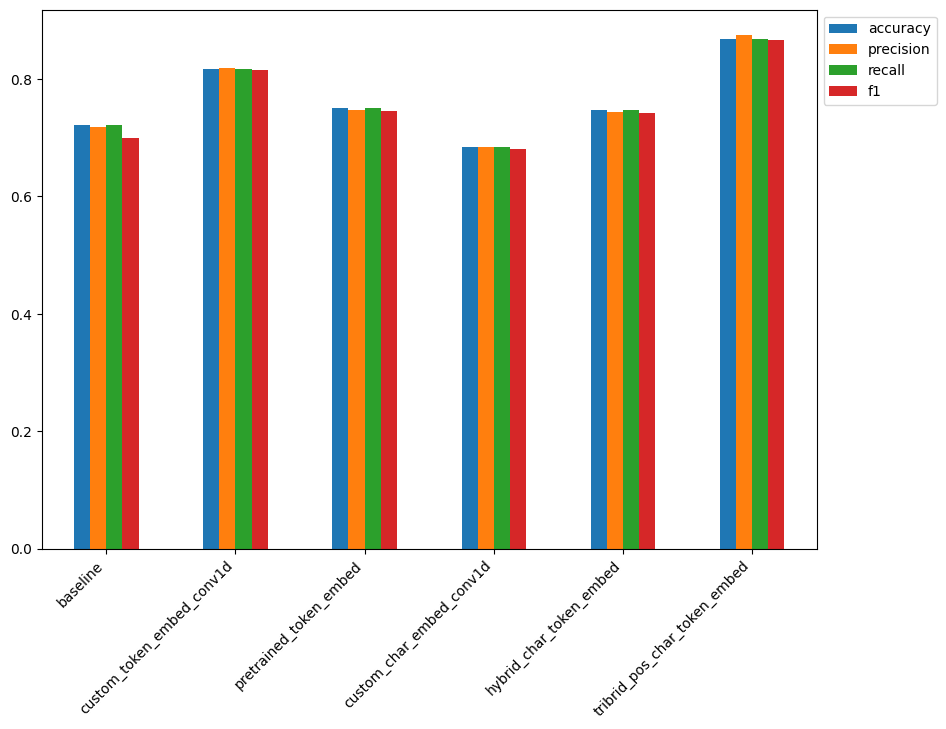

In [ ]:
ax = all_model_results.plot(kind='bar', figsize=(10, 7))
ax.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.show()

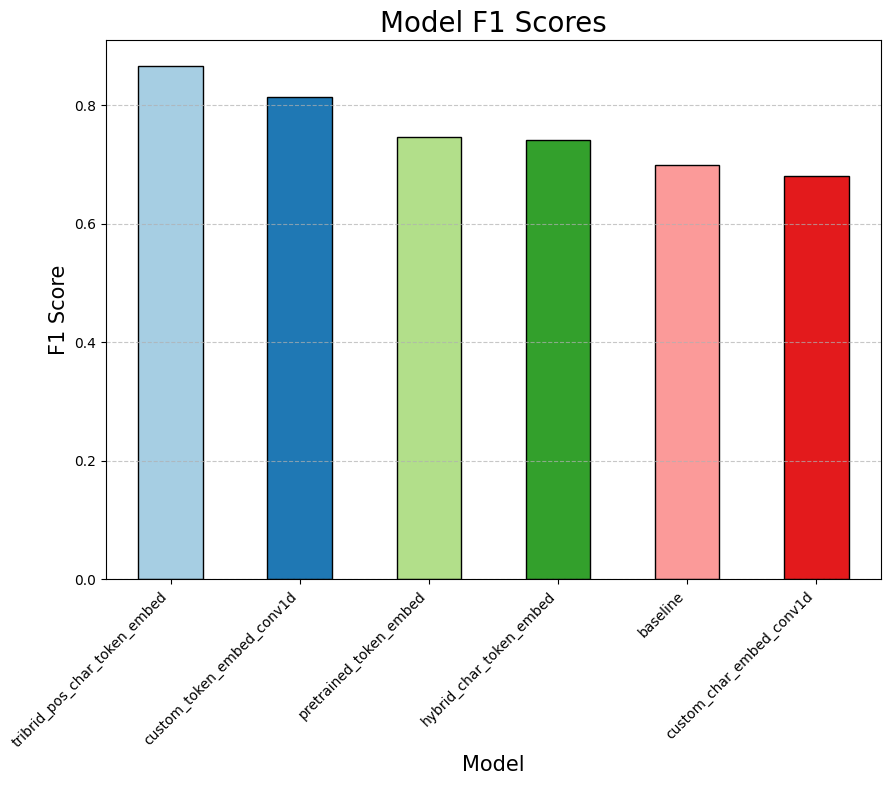

In [ ]:
ax = all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar',
                                                                     figsize=(10, 7),
                                                                     color=plt.cm.Paired(range(len(all_model_results))),
                                                                     edgecolor='black')

ax.set_title('Model F1 Scores', fontsize=20)
ax.set_xlabel('Model', fontsize=15)
ax.set_ylabel('F1 Score', fontsize=15)

plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()